<a href="https://colab.research.google.com/github/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/blob/main/Drivers_Behavior_Detection_with_Smartphone_Signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Behavior Detection with Smartphone Signal Processing

## Project Architecture

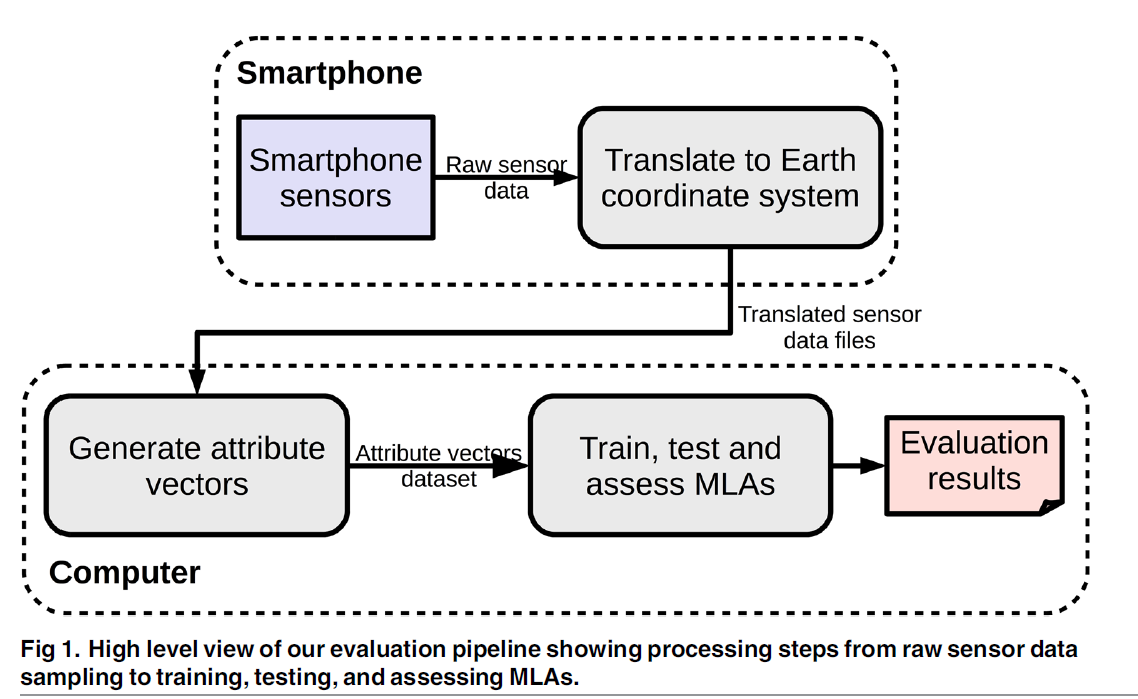

# Loading Data

Source:
- https://data.mendeley.com/datasets/5stn873wft/1
- S. Nazirkar, “Phone sensor data while driving a car and normal or aggressive driving behaviour classification”. Mendeley, 2021. doi: 10.17632/5STN873WFT.1.

Data has been recorded on an android phone attached to the dashboard of the car. Data was collected while driving the car on city roads in mild traffic.
The parameters recorded are:
- Longitude
- Latitude
- Speed
- Distance
- Time
- Accelerometer X
- Accelerometer Y
- Accelerometer Z
- Heading
- Gyroscope X
- Gyroscope Y
- Gyroscope Z

Sampling Rate: Average 2 samples (rows) per second

Driver Behaviors:
    1. Normal driving (Class Label: 0)
    2. Aggressive driving (Class Label: 1)

In [ ]:
# general libraries
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid", rc={ 'figure.figsize': (11, 4)})
import numpy as np
import random
from sklearn.utils import check_random_state  # Used to manage a random_state object
# Set a seed value
seed_value = 42
np.random.seed(42) # Set `numpy` seed
random.seed(42) # Set `random` seed
random_state = check_random_state(42) # Set `sklearn` seed via the random_state parameter in sklearn functions/models
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,matthews_corrcoef, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import joblib
import time
import os

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from filterpy.kalman import KalmanFilter

In [ ]:
path1 = 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/1_20210317_184512.csv'
path2= 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/2_20210317_171452.csv'
path3= 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/3_FinalDatasetCsv.csv'
df1=pd.read_csv(path1)
df1['data_set'] = 1
df2=pd.read_csv(path2)
df2['data_set'] = 2
df3=pd.read_csv(path3)
df3['data_set'] = 3
df_combined = pd.concat([df2,df1])
merged_df = pd.merge(left=df_combined, right=df3, on=['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z'], how='left',
                     suffixes=('_origin', '_new'))

merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

merged_df['label'] = merged_df['label'].astype(int)
merged_df['Time'] = pd.to_datetime(merged_df['Time'], format='%H-%M-%S')

display(merged_df['label'].value_counts().to_frame())


,count
label,
1,6869
0,3300


# EDA

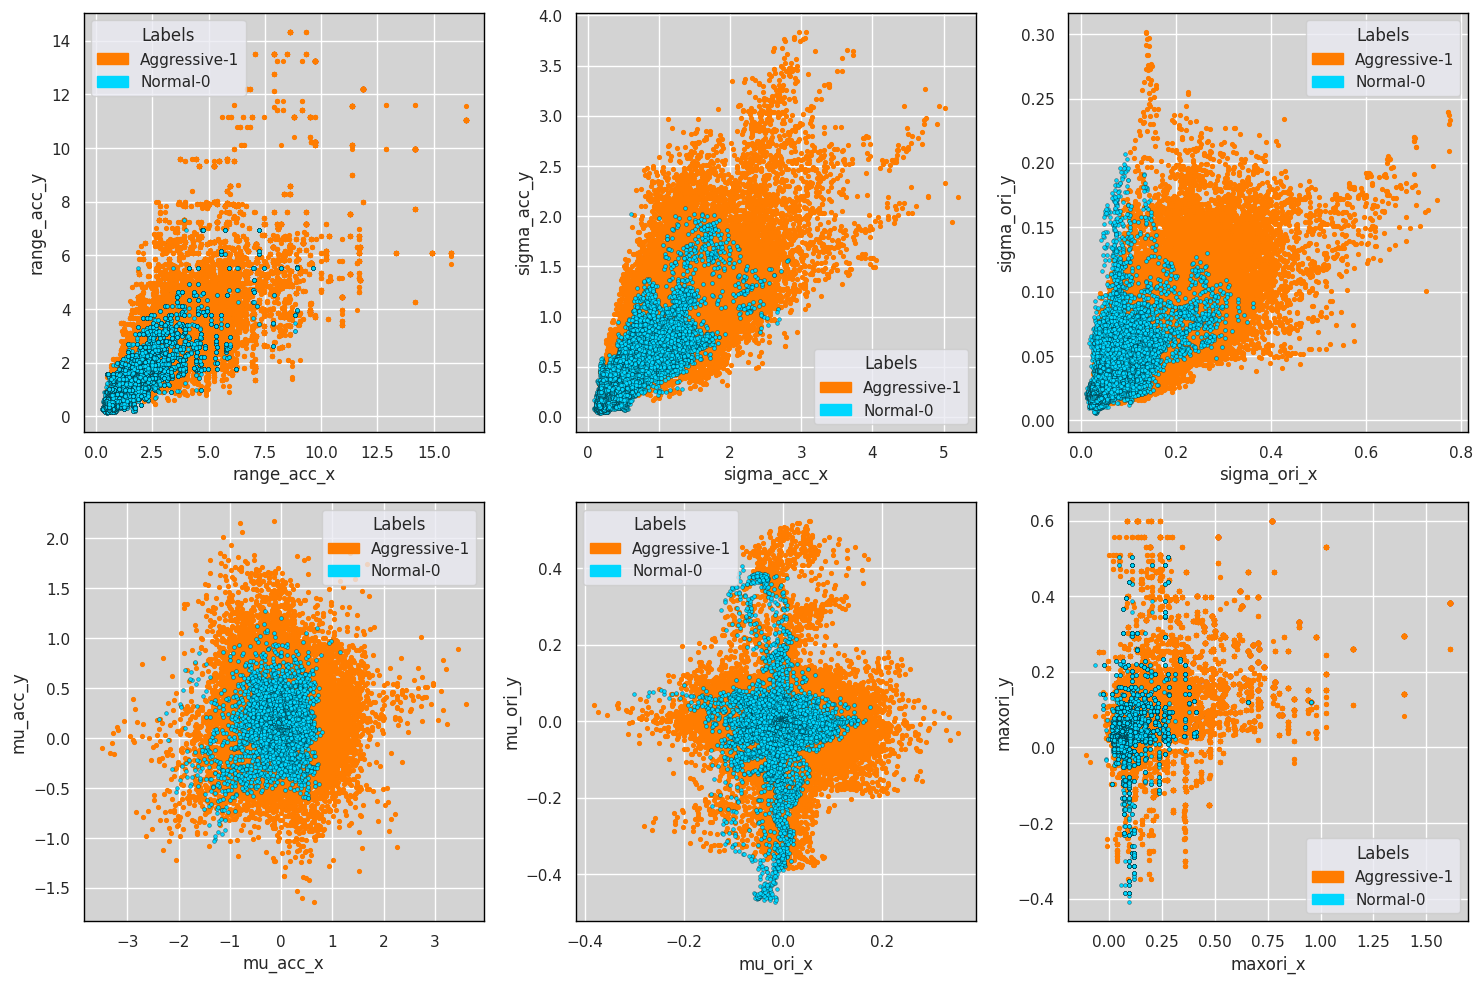

In [ ]:
general_features = sliding_window_features_optimized(merged_df, min_t=5, max_t=10, step=1)
X_general = general_features.drop('label', axis=1)
y_general = general_features['label']
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

#plt.rcParams.update(plt.rcParamsDefault)

columns = ['range_acc', 'sigma_acc', 'sigma_ori', 'mu_acc', 'mu_ori', 'maxori']

# # Create a colormap for red and blue
# cmap = mcolors.ListedColormap(['red', 'blue'])
coolwarm = sns.color_palette("bright", n_colors=10)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as needed

for i, col in enumerate(columns):
    x_col = col + '_x'
    y_col = col + '_y'
    row = i // 3
    col = i % 3

    # Separate the data by label
    data_0 = general_features[general_features['label'] == 0]
    data_1 = general_features[general_features['label'] == 1]

    # Plot the blue samples (label 0) first and then the red samples (label 1)
    axs[row, col].scatter(data_1[x_col], data_1[y_col], color=coolwarm[1], s=7.5)
    axs[row, col].scatter(data_0[x_col], data_0[y_col], color=coolwarm[9], s=7.5, edgecolor='black', linewidth=0.2)

    axs[row, col].set(xlabel=x_col, ylabel=y_col)
    axs[row, col].set_facecolor('lightgray')  # Change the background color to light gray

    # Add grid

    # Create legend
    red_patch = mpatches.Patch(color=coolwarm[1], label='Aggressive-1')
    blue_patch = mpatches.Patch(color=coolwarm[9], label='Normal-0')
    axs[row, col].legend(handles=[red_patch, blue_patch], title="Labels")

    # legend1 = axs[row, col].legend(*scatter.legend_elements(), title="Labels")
    # axs[row, col].add_artist(legend1)

    for _, spine in axs[row, col].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

# Display the plot
plt.tight_layout()
plt.show()

What are the following lines supposed to do?

In [ ]:
# cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
# for col in cols:
#   plt.figure(figsize=(15, 5))
#   sns.scatterplot(data=merged_df, x=merged_df.index, y=col, hue='label')
#   plt.title(f'{col} vs Index, Colored by Label - Full Data')
#   plt.show()

In [ ]:
# cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
# for col in cols:
#   plt.figure(figsize=(15, 5))
#   sns.scatterplot(data=merged_df, x=merged_df.index, y=col, hue='label')
#   plt.title(f'{col} vs Index, Colored by Label - Full Data')
#   plt.show()

# Feature Extraction / Engineering

## Sliding Window Function for Extracting Features

In [ ]:
def compute_rolling_mode(labels, window_size):
    # Convert labels to a DataFrame for vectorized operations
    label_df = pd.DataFrame(labels)
    # Use cumulative sum for 0s and 1s to prepare for differential counting
    cumsum = label_df.cumsum()
    # The shifted cumulative sum gives us the start of the window counts
    shifted_cumsum = cumsum.shift(window_size)
    # The counts within the window are the differences
    window_counts = cumsum - shifted_cumsum.fillna(0)  # Fill NA for the first window
    # Determine the mode (most frequent value) across the window
    # 1 if the count of 1s is greater than half the window size, 0 otherwise
    mode_series = (window_counts >= window_size / 2).astype(int)['label']
    return mode_series

def sliding_window_features_optimized(data, min_t=2, max_t=15, step=1,sample_rate=2):
    sample_rate = sample_rate
    features = []
    numeric_columns = data.select_dtypes(include=[np.number])

    for t in range(min_t, max_t + 1):
        window_size = t * sample_rate # samples per second * window size t
        rolling_windows = numeric_columns.rolling(window=window_size, min_periods=window_size)

        # Compute statistics for each window size
        max_values = rolling_windows.max()
        min_values = rolling_windows.min()
        std_values = rolling_windows.std()
        mean_values = rolling_windows.mean()

        # Calculate mean for first and second halves
        half_window = window_size // 2
        mu_acc_x_1 = numeric_columns['Acc X'].rolling(window=half_window, min_periods=half_window).mean()
        mu_acc_x_2 = numeric_columns['Acc X'].shift(-half_window).rolling(window=half_window, min_periods=half_window).mean()

        # Compute the mode of labels more efficiently
        label_mode = compute_rolling_mode(data['label'], window_size)

        for start in range(window_size - 1, len(data) - window_size + 1, step):
            feature_vector = {
                'time_duration': t,
                'range_acc_x': max_values['Acc X'].iloc[start] - min_values['Acc X'].iloc[start],
                'range_acc_y': max_values['Acc Y'].iloc[start] - min_values['Acc Y'].iloc[start],
                'sigma_acc_x': std_values['Acc X'].iloc[start],
                'sigma_acc_y': std_values['Acc Y'].iloc[start],
                'sigma_ori_x': std_values['gyro_x'].iloc[start],
                'sigma_ori_y': std_values['gyro_y'].iloc[start],
                'mu_acc_x': mean_values['Acc X'].iloc[start],
                'mu_acc_y': mean_values['Acc Y'].iloc[start],
                'mu_ori_x': mean_values['gyro_x'].iloc[start],
                'mu_ori_y': mean_values['gyro_y'].iloc[start],
                'mu_acc_x_1': mu_acc_x_1.iloc[start] if start < len(mu_acc_x_1) else None,
                'mu_acc_x_2': mu_acc_x_2.iloc[start] if start < len(mu_acc_x_2) else None,
                'maxori_x': max_values['gyro_x'].iloc[start],
                'maxori_y': max_values['gyro_y'].iloc[start],
                'minacc_y': min_values['Acc Y'].iloc[start],
                'label': label_mode.iloc[start] if start < len(label_mode) else None,
            }
            features.append(feature_vector)

    return pd.DataFrame(features)


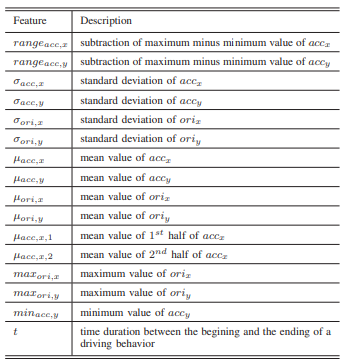

# Train / Test Split (for Time Series)



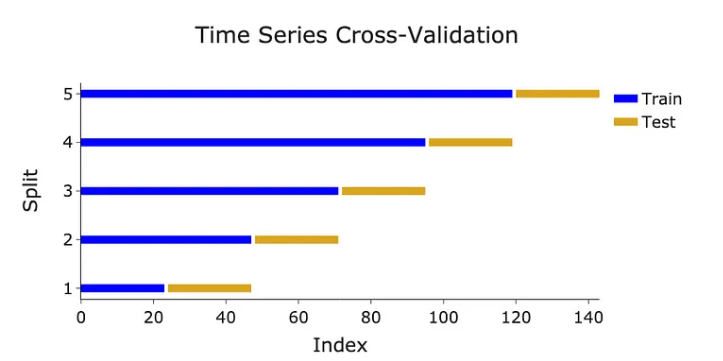

In [ ]:
# Import packages
import plotly.graph_objects as go # TODO - Rewrite without using GO
import pandas as pd
from sklearn.model_selection import KFold


def plot_cross_val(n_splits: int,splitter_func,df: pd.DataFrame,title_text: str) -> None:
    """Function to plot the cross validation of various
    sklearn splitter objects."""

    split = 1
    plot_data = []

    for train_index, valid_index in splitter_func(n_splits=n_splits).split(df):
        plot_data.append([train_index, 'Train', f'{split}'])
        plot_data.append([valid_index, 'Test', f'{split}'])
        split += 1

    plot_df = pd.DataFrame(plot_data,columns=['Index', 'Dataset', 'Split']).explode('Index')

    fig = go.Figure()
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                 y=group['Split'].loc[group['Dataset'] == 'Train'],
                                 name='Train',
                                 line=dict(color="blue", width=10)
                                 ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                 y=group['Split'].loc[group['Dataset'] == 'Test'],
                                 name='Test',
                                 line=dict(color="goldenrod", width=10)
                                 ))

    fig.update_layout(template="simple_white", font=dict(size=20),
                      title_text=title_text, title_x=0.5, width=850,
                      height=250, xaxis_title='Index', yaxis_title='Split')

    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))

    return fig.show()

# Import packages
from sklearn.model_selection import TimeSeriesSplit

# Plot the time series cross validation splits
plot_cross_val(n_splits=2,splitter_func=TimeSeriesSplit,df=merged_df,title_text=f'Time Series Cross-Validation Illustration - {2} Splits')
plot_cross_val(n_splits=3,splitter_func=TimeSeriesSplit,df=merged_df,title_text=f'{3} Splits')
plot_cross_val(n_splits=5,splitter_func=TimeSeriesSplit,df=merged_df,title_text=f'{5} Splits')

# Selecting Best Model and Hyperparameters

In [ ]:
data_processed = sliding_window_features_optimized(merged_df, min_t=2, max_t=7, step=1)

from sklearn.model_selection import train_test_split
X = data_processed.drop('label', axis=1)
y = data_processed['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, shuffle=True)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print("y_train value_counts", y_train.value_counts(normalize=True))
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
# data_processed
print("y_test value_counts", y_test.value_counts(normalize=True))

from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder
def get_class_weights(y):
  # Label encode the target variable
  le = LabelEncoder()
  y_train_encoded = le.fit_transform(y)
  # Calculate class weights
  class_weights = dict(zip(np.unique(y_train_encoded),np.bincount(y_train_encoded) / len(y_train_encoded)))
  return class_weights

class_weights = get_class_weights(merged_df['label'])
print("class_weights: ",class_weights)


class_weights:  {0: 0.32451568492477134, 1: 0.6754843150752287}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.svm import LinearSVC, SVC
import joblib
import time
import os
from sklearn.metrics import classification_report, matthews_corrcoef

# Define the models you want to test
models = {
    'Linear SVM': LinearSVC(),
    'Linear SVM Weight Balanced': LinearSVC(class_weight=class_weights,max_iter=2000,C=0.01),
    'RBF Kernel SVM': SVC(kernel='rbf',probability=True),
    'RBF Kernel SVM Class Weight Balanced': SVC(kernel='rbf',probability=True,class_weight=class_weights),
    'Polynomial Kernel SVM': SVC(kernel='poly',probability=True,),
    'Polynomial Kernel SVM Weight Balanced': SVC(kernel='poly',probability=True,class_weight=class_weights),
    'Sigmoid Kernel SVM': SVC(kernel='sigmoid',probability=True,),
    'Sigmoid Kernel SVM Weight Balanced': SVC(kernel='sigmoid',probability=True,class_weight=class_weights),
}


In [ ]:
preds_dict = models.copy()
for key, _ in preds_dict.items():
  preds_dict[key] = np.nan

In [ ]:
# Dictionary to hold evaluation results
results = []
roc_data = []
# Define the directory path where the model will be saved
directory = f'/content/drive/MyDrive/Models/{time.time()}'
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Evaluate each model
for name, model in models.items():
    print("Training ",name)
    start_time = time.time()  # Start timing
    model.fit(X_train_scaled, y_train)  # Train the model
    end_time = time.time()  # End timing
    training_time = round(end_time - start_time,3)  # Calculate training time
    print(f"Done after {training_time:.2f} seconds")

    # Save the model to the newly created directory
    model_path = os.path.join(directory, f'{model}.pkl')
    # Save the model to a file
    joblib.dump(model, model_path)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None # hasattr is something new I learned in this project!
    preds_dict[name] = y_pred

    # Evaluate the model
    acc = round(accuracy_score(y_test, y_pred),3)
    auc_score = round(roc_auc_score(y_test, y_prob[:, 1]),3) if y_prob is not None else None
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    mcc =  matthews_corrcoef(y_test, y_pred)

    # Store results
    results.append({
        'Model Name': name,'MCC':mcc,'Accuracy': acc,'Auc-Roc': auc_score, 'TP': tp,'FP': fp,'TN': tn,'FN': fn,
        'train_time_secs': training_time})

    # Store data for summary ROC plot
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fpr, tpr, roc_auc, name))

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values(by='MCC', ascending=False)

# Display the DataFrame
display(results_df)
best_model_name = results_df.loc[results_df['MCC'].idxmax()]['Model Name']
best_model = models[best_model_name]



AUC-ROC plot

In [ ]:
sns.set_theme(style="darkgrid", rc={ 'figure.figsize': (10, 5)})
# Plot summary of ROC Curves
# plt.figure(figsize=(6, 5))
for fpr, tpr, roc_auc, name in roc_data:
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC comparison')
plt.legend(loc="lower right")
plt.show()

Confusion matrix of best model

In [ ]:
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
# Create a confusion matrix from the TP, FP, FN, TN values
cm = np.array([[best_model['TN'], best_model['FP']],
               [best_model['FN'], best_model['TP']]])

# Plot the confusion matrix for the best model
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
X_scaled = scaler.fit_transform(X)
scores = cross_val_score(best_model, X_scaled, y, cv=5)
print(f"Cross-validation scores for the best model ({best_model_name}): {scores}")
print(f"Average cross-validation score: {scores.mean()}")

another cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

# Scale your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Create a scorer for MCC
mcc_scorer = make_scorer(matthews_corrcoef)

# Perform cross-validation
scores = cross_val_score(best_model, X_scaled, y, cv=tscv, scoring=mcc_scorer)

print(f"Cross-validation scores for the best model ({best_model_name}): {scores}")
print(f"Average cross-validation score: {scores.mean()}")


gridsearchcv

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import LinearSVC, SVC

# Define the models and parameter grid for each model
models = {
    'LinSVM Weight Balanced': LinearSVC(class_weight=class_weights, max_iter=3000,verbose=True),
     'SVM Class Weight Balanced': SVC(probability=True, class_weight=class_weights,verbose=True),
     'Linear SVM Weight Balanced': LinearSVC(class_weight=class_weights,max_iter=3000),
}

# Define your parameter grids here. This is an example grid.
param_grids = {
    'LinSVM Weight Balanced': {'loss':['hinge','squared_hinge'],
                               'C': [0.1, 1, 10],'tol':[1e4,1e5,1e6,1e7,1e8],},
    # 'SVM Class Weight Balanced': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],'kernel':['rbf', 'poly', 'sigmoid']},
    # 'Linear SVM Weight Balanced': {'C': [0.1, 1, 10]
}

# Scorer for GridSearch
f1_scorer = make_scorer(f1_score, average='weighted')
# Dictionary to hold evaluation results

results = []
roc_data = []
#  Dictionary to store the best parameters and scores
best_results = {}
# Define the directory path where the model will be saved
directory = f'/content/drive/MyDrive/Models/{time.time()}'
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Evaluate each model
for name, model in models.items():
    print("Training ",name)
    grid_search = GridSearchCV(model, param_grids[name], scoring=f1_scorer, cv=5,verbose=4,n_jobs=-1)
    start_time = time.time()  # Start timing
    grid_search.fit(X_train_scaled, y_train)  # Assume X_train, y_train are your data
    best_estimator = grid_search.best_estimator_

    end_time = time.time()  # End timing
    training_time = round(end_time - start_time,3)  # Calculate training time
    print(f"Done after {training_time:.2f} seconds")
    best_results[name] = {
        'Best Parameters': grid_search.best_params_,
    }
    # Save the model to the newly created directory
    model_path = os.path.join(directory, f'{model}.pkl')
    # Save the model to a file
    joblib.dump(model, model_path)

    y_pred = best_estimator.predict(X_test_scaled)
    y_prob = best_estimator.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None # hasattr is something new I learned in this project!
    preds_dict[name] = y_pred

    # Evaluate the model
    acc = round(accuracy_score(y_test, y_pred),3)
    auc_score = round(roc_auc_score(y_test, y_prob[:, 1]),3) if y_prob is not None else None
    f1 = round(f1_score(y_test, y_pred, average='weighted'),3)
    precision = round(precision_score(y_test, y_pred, average='weighted'),3)
    recall = round(recall_score(y_test, y_pred, average='weighted'),3)
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

    # Store results
    results.append({
        'Model Name': name,'Accuracy': acc,'Auc-Roc': auc_score,'TP': tp,'FP': fp,'TN': tn,'FN': fn,
        'train_time_secs': training_time})

    # Store data for summary ROC plot
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fpr, tpr, roc_auc, name))

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)

# Display the DataFrame
display(results_df)



New part which I don't understand

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.base import clone

# Define a custom scorer if necessary
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True,class_weight=class_weights)

# Define the model pipeline
pipe = Pipeline([
      ('scale', StandardScaler()),  # Add scaler
      ('svc', SVC(probability=True, verbose=True))  # Add SVC model
])

# Define parameter grid
param_grid = {# 'svc__C': [0.05, 0.1],
    'svc__C': [ 0.1],# 'svc__kernel': ['linear', 'poly', 'rbf','sigmoid'],
    'svc__kernel': ['linear', ],}

# Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2,gap=10)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={'F1': 'f1_weighted'},  # Change scoring to f1_weighted for multiclass or binary outcomes
    refit='F1',  # Refit an estimator using the best found parameters on the whole dataset.
    cv=tscv,
    verbose=4,
    n_jobs=-1  # Use all available cores
)

# Load your data
data = sliding_window_features_optimized(merged_df, min_t=2, max_t=7, step=1)

# Assume `merged_df` is your DataFrame and has been properly prepared (features and label variable)
X = data.drop('label', axis=1)
y = data['label']

# Run the grid search
grid_search.fit(X, y)

# Get the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best model parameters:", best_params)
print("Best model score (F1):", best_score)

# Optionally, review the full results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df['min_t'] = min_t
results_df['max_t'] = max_t
results_df['step'] = step
display(results_df[['param_svc__C', 'param_svc__kernel', 'mean_test_F1', 'rank_test_F1']])


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[LibSVM]Best model parameters: {'svc__C': 0.1, 'svc__class_weight': {0: 0.32451568492477134, 1: 0.6754843150752287}, 'svc__kernel': 'linear'}
Best model score (F1): 0.8539500248737444


,param_svc__C,param_svc__kernel,mean_test_F1,rank_test_F1
0,0.1,linear,0.853950,1
1,0.1,poly,0.843134,2
2,0.1,rbf,0.763275,3


In [ ]:
from sklearn.preprocessing import LabelEncoder
def get_class_weights(y):
  # Label encode the target variable
  le = LabelEncoder()
  y_train_encoded = le.fit_transform(y)
  # Calculate class weights
  class_weights = dict(zip(np.unique(y_train_encoded),np.bincount(y_train_encoded) / len(y_train_encoded)))
  return class_weights
min_t=2
max_t=7

data = sliding_window_features_optimized(merged_df, min_t=min_t, max_t=max_t, step=step)
class_weights = get_class_weights(data['label'])
print("class_weights: ",class_weights)


class_weights:  {0: 0.3238944154437112, 1: 0.6761055845562888}


In [ ]:
# Define a custom scorer if necessary
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True,class_weight=class_weights)

# Define the model pipeline
pipe = Pipeline([('scale', StandardScaler()),  # Add scaler
      ('svc', SVC(probability=True, verbose=True))  # Add SVC model
])

# Define parameter grid
param_grid = {  'svc__C': [0.1],# 'svc__C': [ 0.1],
               'svc__kernel': ['linear', 'poly', 'rbf','sigmoid'],}# 'svc__kernel': ['linear', ],}

# Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5,gap=1)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid,    scoring={'accuracy': 'accuracy','auc': 'roc_auc',
        'mcc': make_scorer(matthews_corrcoef),  # Adding custom scorer for Matthews correlation coefficient
        'f1': 'f1','precision': 'precision','recall': 'recall',}, refit='mcc',  # Refit an estimator using the best found parameters on the whole dataset.
    cv=tscv,verbose=4, n_jobs=-1 )

step=1

min_t=2
max_t=7

data = sliding_window_features_optimized(merged_df, min_t=min_t, max_t=max_t, step=step)

# Assume `merged_df` is your DataFrame and has been properly prepared (features and label variable)
X = data.drop('label', axis=1)
y = data['label']

# Run the grid search
grid_search.fit(X, y)

# Get the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best model parameters:", best_params)
print("Best model score (F1):", best_score)

# Optionally, review the full results
temp_results_df = pd.DataFrame(grid_search.cv_results_)
temp_results_df['min_t'] = min_t
temp_results_df['max_t'] = max_t
temp_results_df['method'] = 1
temp_results_df.columns = [col.replace('test_', '') for col in temp_results_df.columns]
temp_results_df.columns = [col.replace('mean_', '') for col in temp_results_df.columns]
bot.send_message(chat_id, 'Code finished running Master.')
bot.send_message(chat_id, f'best_score: {best_score}.')
bot.send_message(chat_id, f'best_params: {best_params}.')
# results.append(temp_results_df.values)
temp_results_df.columns = [col.replace('test_', '') for col in temp_results_df.columns]
results_df = pd.concat([results_df, temp_results_df])
# display(results_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LibSVM]Best model parameters: {'svc__C': 0.1, 'svc__kernel': 'rbf'}
Best model score (F1): 0.6699274395952797


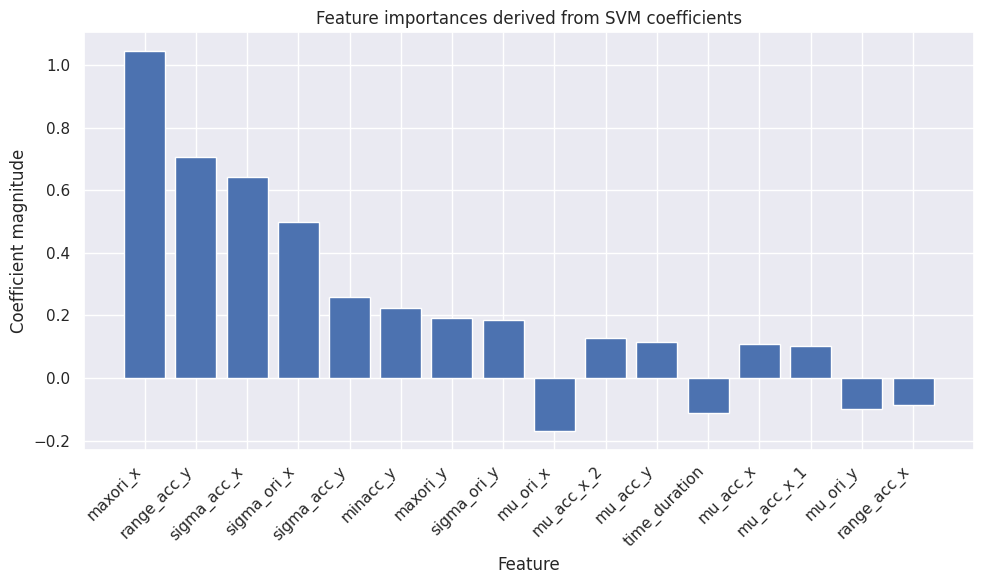

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'best_model' is your pipeline containing an SVC with a linear kernel
# 'X_general' should be your feature dataset with column names
feature_names = X_general.columns

# Accessing the SVM model's coefficients from the pipeline
svm_model = best_model.named_steps['svc']  # replace 'svc' with the actual name used in your pipeline
coefficients = svm_model.coef_[0]  # Accessing the coefficients

# Sorting the features by the absolute value of their coefficients
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature importances derived from Linear SVM coefficients")
plt.bar(range(len(coefficients)), coefficients[sorted_indices], align='center')
plt.xticks(range(len(coefficients)), feature_names[sorted_indices], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.tight_layout()
plt.show()


# Inference Visualizations